# Multivariate Time Series Forecasting with LSTMs in Keras
#### Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

### Train On Single Lag Timestep - 1 meter

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 


Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [3]:
# load dataset
#dataset = read_csv('DFS04690650Rand.txt', header=0, index_col=0)
dataset = read_csv('DFS04690650Rand.txt', header=0, sep='[\t]', parse_dates=True, squeeze=True, dayfirst=True, engine='python')
dataset.dtypes
print(dataset.head())
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.dtypes
# drop columns we don't want to predict
reframed.drop(reframed.columns[[10,11,12,13,15,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())

         Temp  NoBeds  Area_m2  Const_Year  kWh  Month  Weekday  Seconds  \
5300   15.625       1     64.6        2017    0      8        3    83700   
10965   6.050       1     64.6        2017    0     11        1     2700   
16481   4.975       1     64.6        2017    1      5        1    58500   
15647  -0.775       1     64.6        2017    0     11        4    24300   
18619   7.325       1     64.6        2017    1     12        5    76500   

       Daytime  Holiday  
5300         0        0  
10965        0        0  
16481        1        0  
15647        0        0  
18619        1        1  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.736979        0.0        0.0        0.0        0.0   0.636364   
2   0.404514        0.0        0.0        0.0        0.0   0.909091   
3   0.367187        0.0        0.0        0.0        0.2   0.363636   
4   0.167535        0.0        0.0        0.0        0.0   0.909091   
5   0.448785        0.0        0

In [5]:
# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 


(16243, 1, 10) (16243,) (4061, 1, 10) (4061,)


Train on 16243 samples, validate on 4061 samples
Epoch 1/100
 - 4s - loss: 0.0171 - val_loss: 0.0141
Epoch 2/100
 - 2s - loss: 0.0152 - val_loss: 0.0138
Epoch 3/100
 - 2s - loss: 0.0151 - val_loss: 0.0140
Epoch 4/100
 - 2s - loss: 0.0152 - val_loss: 0.0143
Epoch 5/100
 - 2s - loss: 0.0150 - val_loss: 0.0138
Epoch 6/100
 - 2s - loss: 0.0150 - val_loss: 0.0139
Epoch 7/100
 - 2s - loss: 0.0151 - val_loss: 0.0138
Epoch 8/100
 - 2s - loss: 0.0150 - val_loss: 0.0137
Epoch 9/100
 - 2s - loss: 0.0150 - val_loss: 0.0138
Epoch 10/100
 - 2s - loss: 0.0151 - val_loss: 0.0143
Epoch 11/100
 - 2s - loss: 0.0150 - val_loss: 0.0146
Epoch 12/100
 - 2s - loss: 0.0149 - val_loss: 0.0136
Epoch 13/100
 - 2s - loss: 0.0150 - val_loss: 0.0141
Epoch 14/100
 - 2s - loss: 0.0150 - val_loss: 0.0142
Epoch 15/100
 - 2s - loss: 0.0150 - val_loss: 0.0141
Epoch 16/100
 - 2s - loss: 0.0149 - val_loss: 0.0145
Epoch 17/100
 - 2s - loss: 0.0150 - val_loss: 0.0138
Epoch 18/100
 - 2s - loss: 0.0149 - val_loss: 0.0139
Epoch 

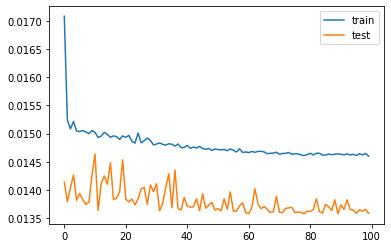

In [6]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.show()
 


In [7]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.552
